# TeslaMax Optimization

Teslamax model:

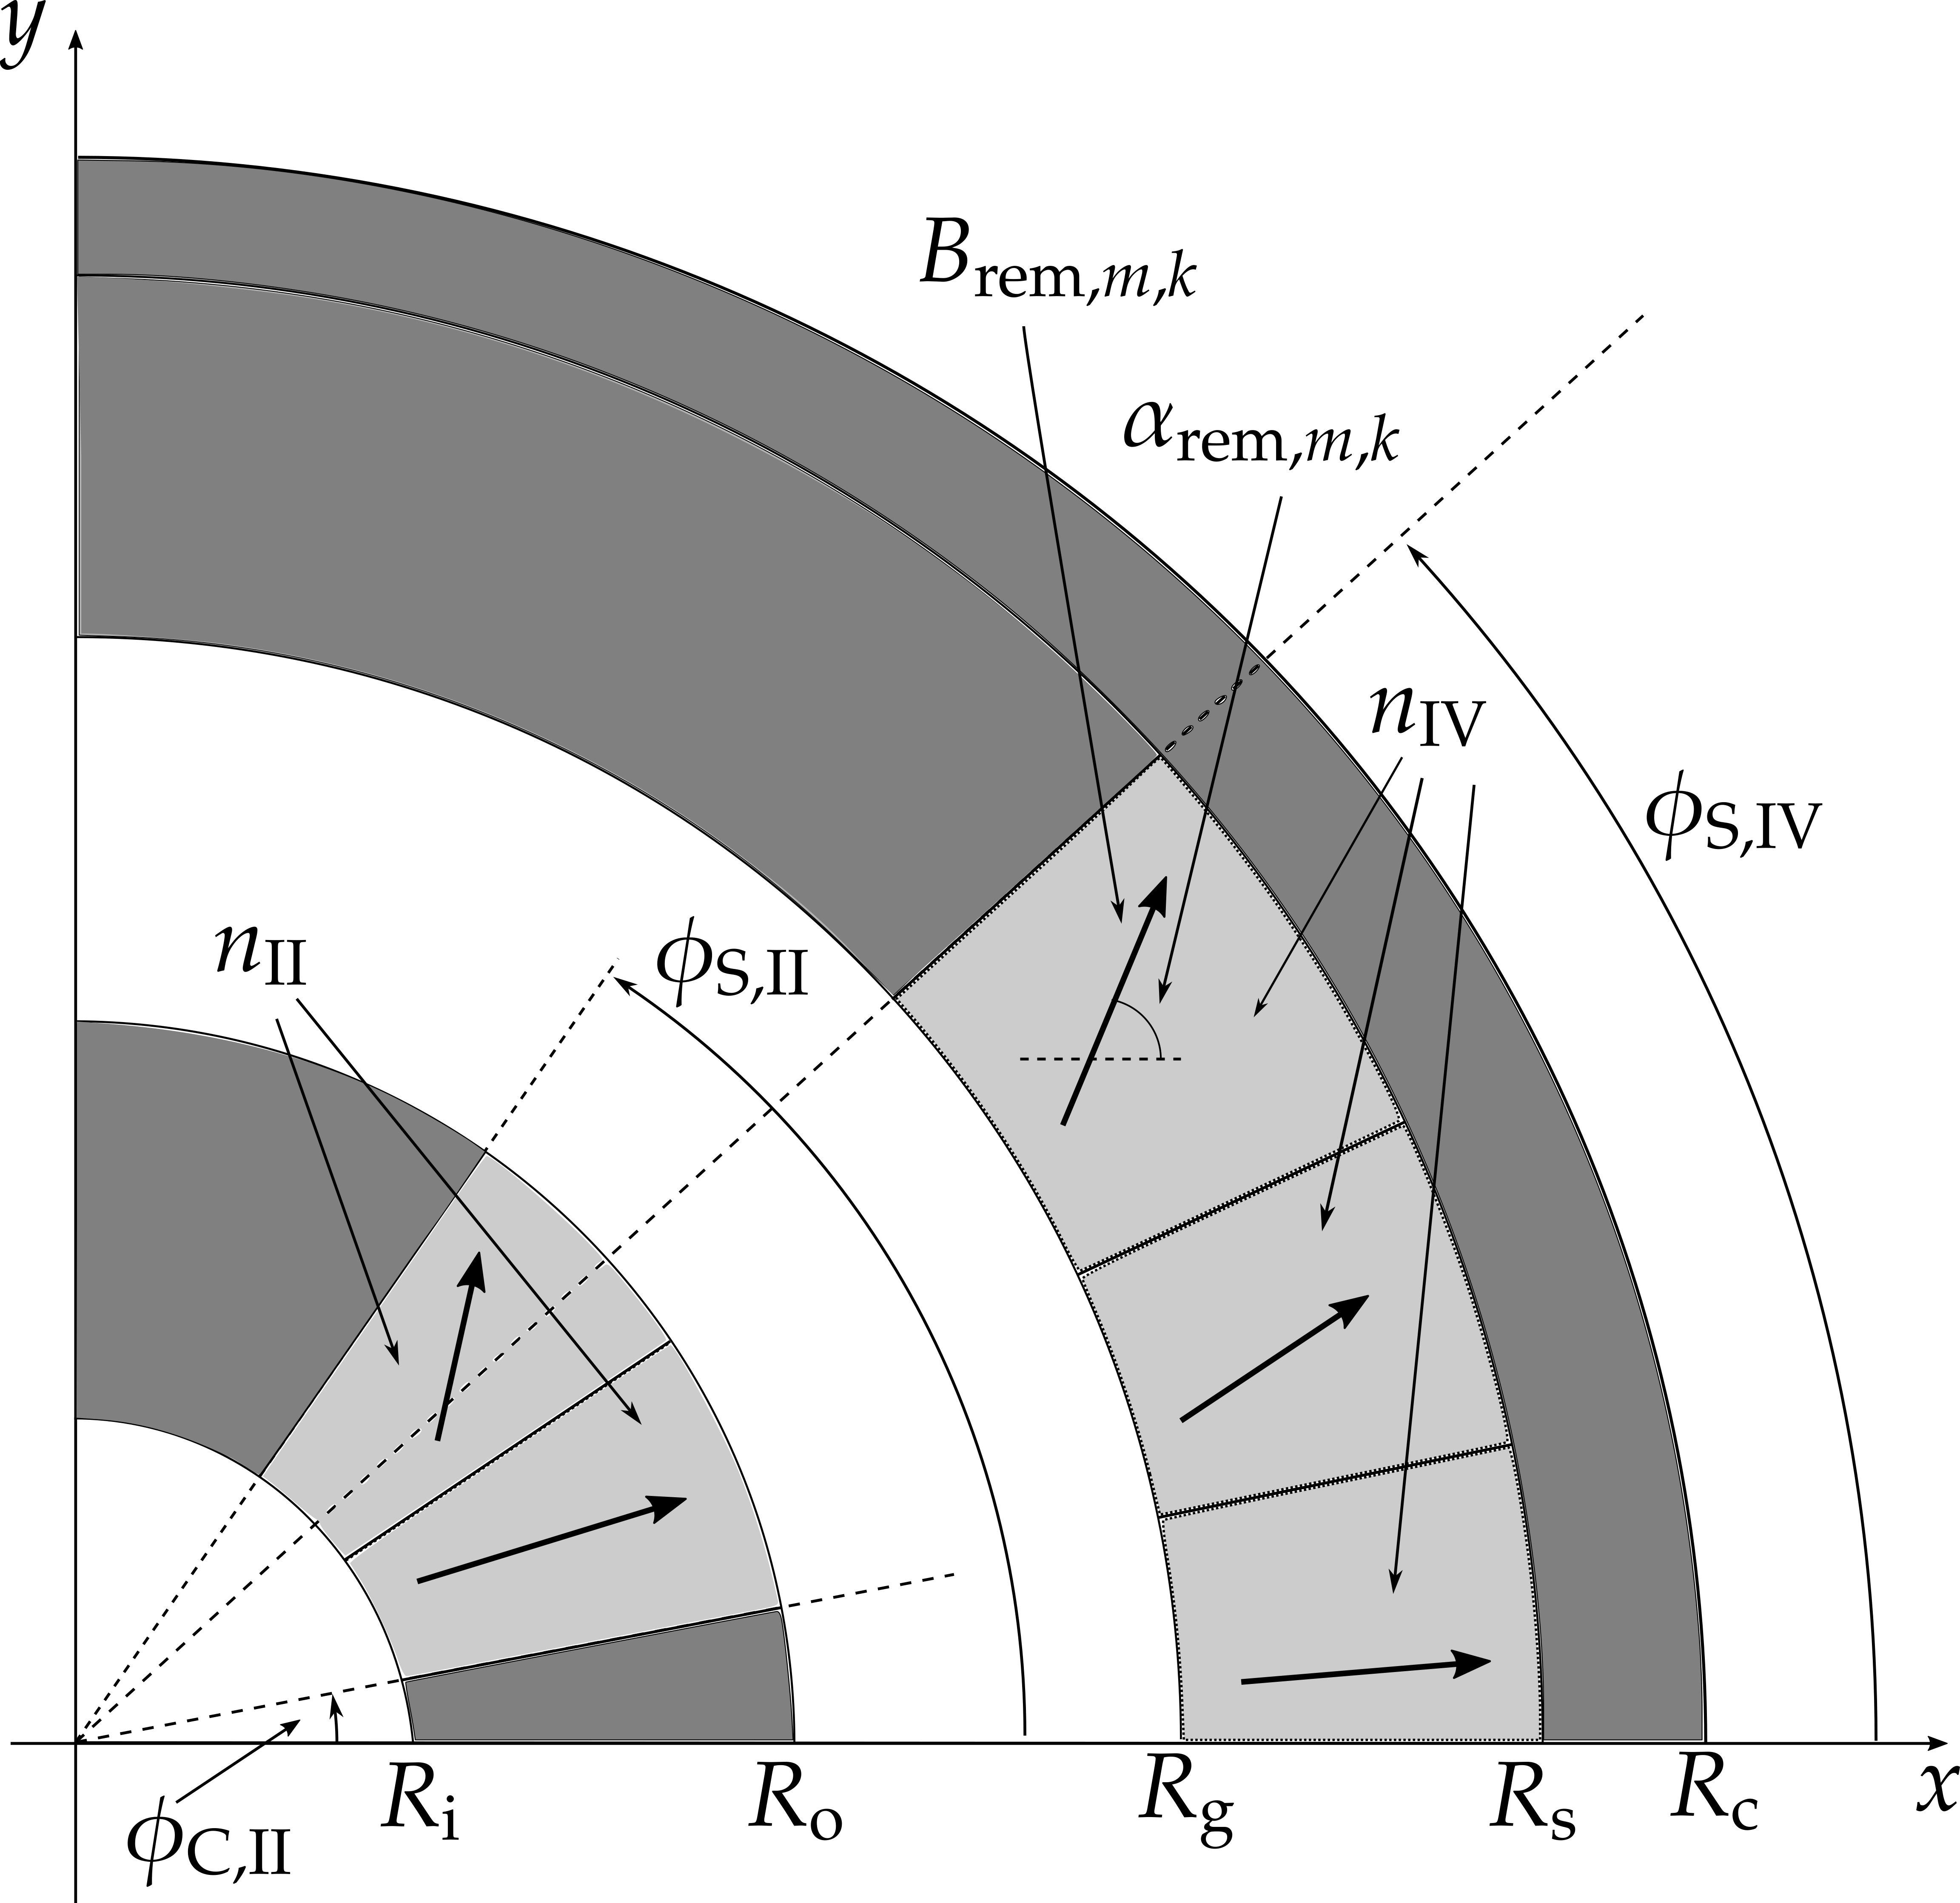

In [1]:
from IPython.display import Image, display, HTML
Image("figures/teslamax.png",width=500)

We are intererested in finding the optimal set of remanence angles $\alpha_{\mathrm{rem},m,k}$ that will maximize some metric in the air gap.

In [2]:
from pathlib import Path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from pandas import Series, DataFrame
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

In [3]:
B_HIGH_LIMIT = 1.2

TESLAMAX_PATH = Path.home() / "code" / "TeslaMax"

PLAYGROUND_DIR = "teslamax-play"

RAMP_RESULTS_DIR_FMT = "ramp_Bh_%d_FM_%d"

In [4]:
os.chdir(TESLAMAX_PATH)

In [5]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

## Objective function

We consider that the magnetic profile is a good representation of what the regenerators experience, and it is what is used as an input to AMR models. Therefore, the optimization procedure that is developed here is denoted *profile matching*: we calculate the optimal remanence angles for each magnet segments, such that the deviation between the resulting profile and a *target* ramp profile is minimized:

$$
\mathcal{K}(\vec{x}) = \frac{1}{2\pi}\left(\int_0^{2\pi}\left( \frac{\overline{B}(\phi,\vec{x}) - \overline{B}_{\mathrm{ramp}} (\phi,B_{\mathrm{min}},B_{\mathrm{max}})}{B_{\mathrm{max}} - B_{\mathrm{min}}} \right)^{2}\mathrm{d}\phi\right)
$$

where $\overline{B}(\phi,\vec{x})$ is the magnetic profile calculated at position $\phi$ when the remanence angles are represented by $\vec{x}$, and $\overline{B}_{\mathrm{ramp}} \left(\phi,B_{\mathrm{min}},B_{\mathrm{max}},F_{\mathrm{M}})\right)$ is the ramp profile at angle $\phi$, between plateaus $B_{\mathrm{min}}$ and $B_{\mathrm{max}}$ for the low and high field regions, with a high field fraction $F_{\mathrm{M}}$ (the fraction of the entire cycle where the field is at the high level).

## Optimization using Scipy

In [6]:
def optimize_ramp(B_high,field_fraction,params):
    """
    Run the TeslaMax optimization procedure, trying to match the profile
    to a ramp profile between 0 and 'B_high' with 'field_fraction', using the
    parameters in the dictionary 'params'.
    
    Return a TeslaMaxModel object, representing the optimized magnet,
    and the value of the cost function. The TeslaMaxModel object is already populated with simulation results.
    
    The simulation results are stored in directories inside "teslamax-play".
    """
    
    tmpd = TeslaMaxPreDesign(params)
    
    target_function = teslamax.calculate_ramp_profile
    
    B_low = 0.0
    
    target_args = (B_high,B_low,field_fraction)

    alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
    cost_function = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)
    
    sdir = RAMP_RESULTS_DIR_FMT %(B_high*1e3, field_fraction*1e2) 
    
    teslamax_playground = str(TESLAMAX_PATH / PLAYGROUND_DIR / sdir )
    
    tmm_g = TeslaMaxModel(tmpd,
                          alpha_B_rem_g,
                          path=teslamax_playground)
    tmm_g.run()
    
    return (tmm_g,cost_function)
    

In [7]:
import nemplot
from nemplot import nemplot_parameters

In [8]:
nemplot.set_dpi(1500)
nemplot.set_fontsize(22)
nemplot.set_latex_font("Palatino")

In [9]:
def refine_list(original_list, factor):
    """
    Return a new list, inserting more elements between the number in 'original_list'.
    
    Assumes 'original_list' is evenly-spaced. The spacing between each element is divided by 'factor'
    
    >>>refine_list([1,2,3],factor=2)
    [1.0,1.5,2.0,2.5,3.0]
    """
    
    # calculate the original spacing between elements and refine it
    d = original_list[1] - original_list[0]
    d_refined = d / factor
        
    max_value = max(original_list)
    min_value = min(original_list)
    
    # the number of elements is the number of divisions between the limit values, plus one aditional
    n_refined = ((max_value - min_value) / d_refined) + 1
        
    return np.linspace(min_value,max_value,int(n_refined))

In [10]:
def plot_optimized_ramp(B_high,field_fraction):
    """
    Plot a comparison between the magnetic profile from the TeslaMax simulations
    and a ramp profile between 0 and 'B_high', with 'field_fraction'. The TeslaMax
    results are read from the appropriate files inside PLAYGROUND_DIR.
    
    Save the figure with the appropriate naming inside the 'figures' directory.
    """
 

    sdir = RAMP_RESULTS_DIR_FMT %(B_high*1e3, field_fraction*1e2) 
    
    teslamax_playground = TESLAMAX_PATH / PLAYGROUND_DIR / sdir
    
    profile_file = teslamax_playground / teslamax.MAGNETIC_PROFILE_FILENAME
    
    profile_fig_g, profile_axes_g = nemplot.create_plot(xlabel=r'$\phi [\si{\degree}]$',
                                                       ylabel=r'$B [\si{\tesla}]$')
    
    phi_vector_g, B_vector_g = teslamax.read_comsol_profile_data(str(profile_file))
    
    lw = 2.0
    profile_axes_g.plot(phi_vector_g,B_vector_g,linewidth=lw)
    profile_axes_g.set_xlim(0,np.max(phi_vector_g))
    profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_g),9))
    profile_axes_g.grid(True)
    profile_axes_g.set_ylim(0,B_HIGH_LIMIT)
    
    ticks = profile_axes_g.get_yticks()
    profile_axes_g.set_yticks(refine_list(ticks,4),minor=True)
        
    #profile_axes_g.set_yticks(np.arange(0,B_HIGH_LIMIT+0.2,0.2),minor=True)
    
    B_low = 0.0
    B_inst_vector = teslamax.calculate_ramp_profile(phi_vector_g,B_high,B_low,field_fraction)
    profile_axes_g.plot(phi_vector_g,B_inst_vector,'--',linewidth=lw)

    nemplot.save_figure(profile_fig_g,"profile_optimized_B_%d_FM_%d" %(B_high*1000,field_fraction*100))

### Compact magnet

These are the parameters that are being used to study more compact systems:

In [1]:
# Fixed parameters

FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3,
    "W[m]": 30e-3,
    "N_r[]": 8,
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05}

FIXED_PARAMETERS_MAGNET = {"R_i": 0.015,
                "R_o": 0.040,
                "h_fc": 0.005,
                "R_e": 0.3,
                "n_II": 2,
                "n_IV": 4,
                "phi_C_II": 15,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

NameError: name 'np' is not defined

In [12]:
# variable parameters

params_optimization_2 = FIXED_PARAMETERS_MAGNET.copy()

params_optimization_2["H[m]"] = 17e-3

params_optimization_2["R_s"] = 105e-3
params_optimization_2["phi_S_II"] = 45
params_optimization_2["phi_S_IV"] = params_optimization_2["phi_S_II"]

params_optimization_2["h_gap"] = params_optimization_2["H[m]"] + 2*(FIXED_PARAMETERS_AMR["t_casing[m]"] + 
                                                                    FIXED_PARAMETERS_AMR["t_air[m]"])


field_fraction = 0.35

In [13]:
n_II = params_optimization_2["n_II"]
n_IV = params_optimization_2["n_IV"]

n = n_II + n_IV

B_rem = 1.4

# expand parameters to include remanence magnitudes for each segment
params_optimization_2 = teslamax.expand_parameters_from_remanence_array(B_rem*np.ones(n), 
                                                                      params_optimization_2, 
                                                                      "B_rem")

We test three different values of the high field to study the scale of K:

In [14]:
%%time

B_high = 1.0

tmm_g_2, K_2 = optimize_ramp(B_high,field_fraction,params_optimization_2)

print("Value of the objective function:")
print(K_2)

Value of the objective function:
0.0010050335620501872
Wall time: 6min 50s


In [2]:
%matplotlib inline

plot_optimized_ramp(B_high,field_fraction)

NameError: name 'plot_optimized_ramp' is not defined

In [16]:
%%time

B_high = 1.07

tmm_g_2, K_2 = optimize_ramp(B_high,field_fraction,params_optimization_2)

print("Value of the objective function:")
print(K_2)

Value of the objective function:
0.0010638632241414042
Wall time: 7min 12s


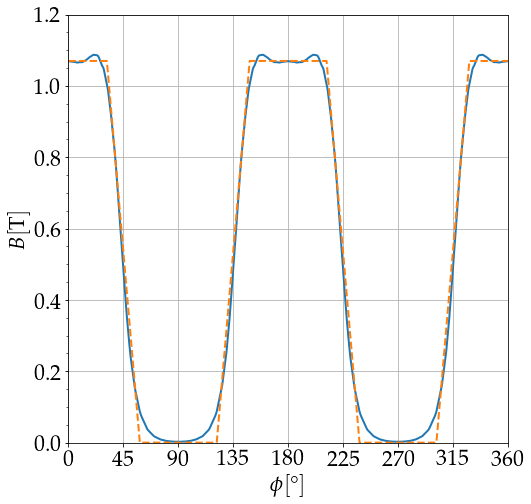

In [17]:
%matplotlib inline

plot_optimized_ramp(B_high,field_fraction)

In [18]:
params_optimization_2

{'R_i': 0.015,
 'R_o': 0.04,
 'h_fc': 0.005,
 'R_e': 0.3,
 'n_II': 2,
 'n_IV': 4,
 'phi_C_II': 15,
 'mu_r_II': 1.05,
 'mu_r_IV': 1.05,
 'linear_iron': 1,
 'mu_r_iron': 5000.0,
 'H[m]': 0.017,
 'R_s': 0.105,
 'phi_S_II': 45,
 'phi_S_IV': 45,
 'h_gap': 0.02,
 'B_rem_II_1': 1.4,
 'B_rem_II_2': 1.4,
 'B_rem_IV_1': 1.4,
 'B_rem_IV_2': 1.4,
 'B_rem_IV_3': 1.4,
 'B_rem_IV_4': 1.4}

In [19]:
%%time

B_high = 1.1

tmm_g_2, K_2 = optimize_ramp(B_high,field_fraction,params_optimization_2)

print("Value of the objective function:")
print(K_2)

Value of the objective function:
0.0013865460143646553
Wall time: 7min 14s


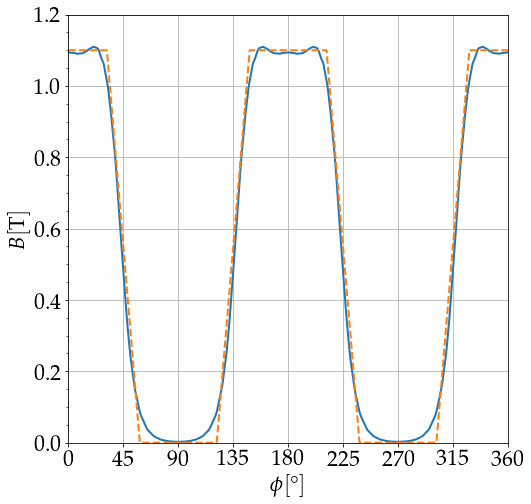

In [20]:
%matplotlib inline

plot_optimized_ramp(B_high,field_fraction)

In [21]:
%%time

B_high = 1.12

tmm_g_2, K_2 = optimize_ramp(B_high,field_fraction,params_optimization_2)

print("Value of the objective function:")
print(K_2)

Value of the objective function:
0.0017753606670457042
Wall time: 7min 5s


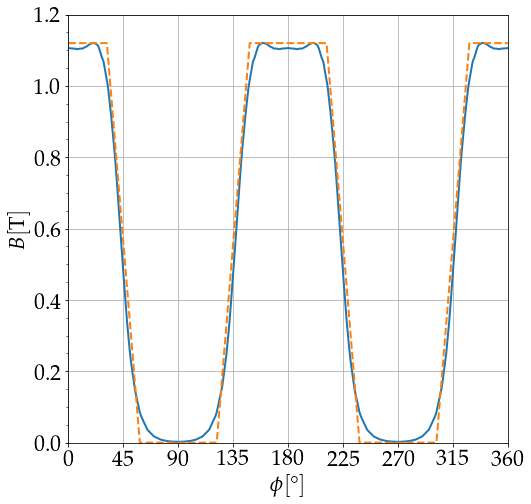

In [22]:
%matplotlib inline

plot_optimized_ramp(B_high,field_fraction)

So it seems that, based on visual inspection, the optimization procedure is acceptable if $K \le 0.002$.

## Large magnets

In [11]:
B_HIGH_LIMIT = 1.2
FIELD_FRACTION = 0.35
B_REM = 1.26

In [12]:
# Fixed parameters

FIXED_PARAMETERS_LARGE_MAGNET = {"R_i": 0.030,
                "h_fc": 0.015,
                "R_s": 250e-3,
                "R_o": 194.71e-3,
                "R_g": 209.75e-3,
                "R_e": 1,
                "n_II": 5,
                "n_IV": 5,
                "phi_C_II": 0,
                "phi_S_II": 60,
                "phi_S_IV": 60,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 1e3,
            "l_element_min": 1e-3,
            "l_element_max": 3e-2,
            "n_narrow": 2,
             }

n_II = FIXED_PARAMETERS_LARGE_MAGNET["n_II"]
n_IV = FIXED_PARAMETERS_LARGE_MAGNET["n_IV"]

n = n_II + n_IV

# expand parameters to include remanence magnitudes for each segment
FIXED_PARAMETERS_LARGE_MAGNET = teslamax.expand_parameters_from_remanence_array(B_REM*np.ones(n), 
                                                                      FIXED_PARAMETERS_LARGE_MAGNET, 
                                                                      "B_rem")

In [13]:
%%time

B_high = 0.733

params_magnet_large = FIXED_PARAMETERS_LARGE_MAGNET.copy()

tmm_g_large, K_large = optimize_ramp(B_high,FIELD_FRACTION,params_magnet_large)

print("Value of the objective function:")
print(K_large)

Value of the objective function:
0.02168251853960798
Wall time: 23min 42s


C:\Users\fabiofortkamp\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


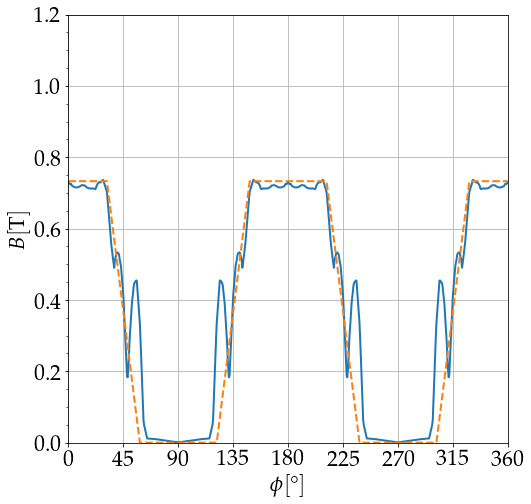

In [14]:
%matplotlib inline

plot_optimized_ramp(B_high,FIELD_FRACTION)

In [15]:
%%time

B_high = 0.5

params_magnet_large = FIXED_PARAMETERS_LARGE_MAGNET.copy()

tmm_g_large, K_large = optimize_ramp(B_high,FIELD_FRACTION,params_magnet_large)

print("Value of the objective function:")
print(K_large)

Value of the objective function:
0.050458338590389805
Wall time: 28min 31s


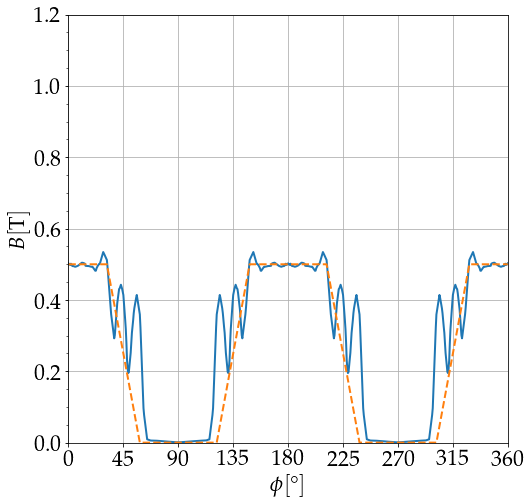

In [16]:
%matplotlib inline

plot_optimized_ramp(B_high,FIELD_FRACTION)

In [17]:
%%time

B_high = 1.0

params_magnet_large = FIXED_PARAMETERS_LARGE_MAGNET.copy()

tmm_g_large, K_large = optimize_ramp(B_high,FIELD_FRACTION,params_magnet_large)

print("Value of the objective function:")
print(K_large)

Value of the objective function:
0.02366728905330973
Wall time: 11min 21s


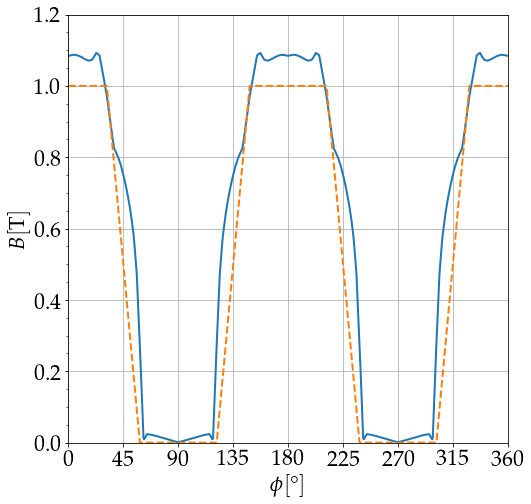

In [19]:
%matplotlib inline

plot_optimized_ramp(B_high,FIELD_FRACTION)

In [24]:
%%time

B_high = 1.15

params_magnet_large = FIXED_PARAMETERS_LARGE_MAGNET.copy()

tmm_g_large, K_large = optimize_ramp(B_high,FIELD_FRACTION,params_magnet_large)

print("Value of the objective function:")
print(K_large)

Value of the objective function:
0.007832781017818837
Wall time: 20min 54s


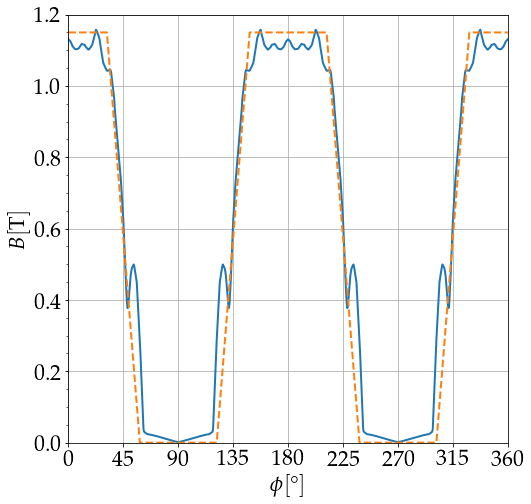

In [25]:
%matplotlib inline

plot_optimized_ramp(B_high,FIELD_FRACTION)